In [83]:
import tensorflow as tf
# if the import fails, try to install tf : pip install --upgrade tensorflow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy.random as rnd
import numpy as np
import os
import matplotlib.pyplot as plt

rep = "."

# Exercice 1: Comparision with PCA

## Dataset generation

C:\Users\Shadr\AppData\Local\Temp/ipykernel_10764/107518409.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


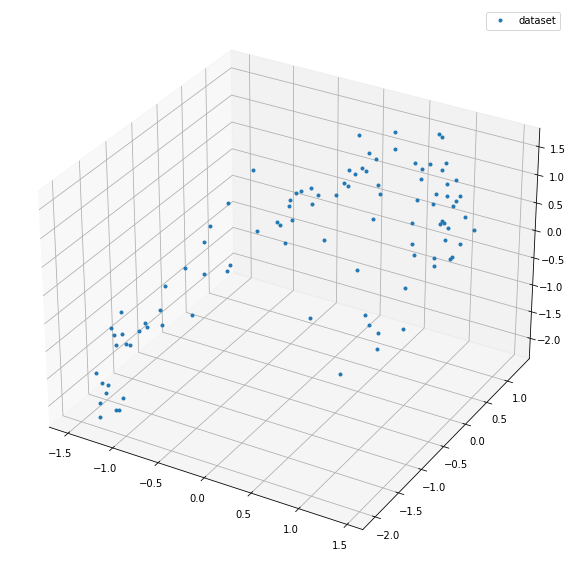

In [84]:
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100]).astype('float32')
X_test = scaler.transform(data[100:]).astype('float32')

fig = plt.figure(figsize=(10,25))
ax = fig.gca(projection='3d')
ax.plot(X_train[:,0], X_train[:,1], X_train[:,2],'.', label='dataset')
ax.legend()
plt.show()

## Dimensionality reduction with an auto-encoder

In [85]:
d_in = 3 #input dimensionality
d_hid = 2 #code dimensionality
d_out = d_in #output dimensionality
learning_rate = 0.1

activation = tf.nn.elu

class basic_AE(tf.Module):
    def __init__(self, unit_nbrs, name=None):
        super().__init__(name=name)
        self.w1 = tf.Variable(tf.random.normal([d_in, d_hid]), name='w')
        self.b1 = tf.Variable(tf.zeros([d_hid]), name='b1')
        self.b2 = tf.Variable(tf.zeros([d_in]), name='b2')
        self.K = len(unit_nbrs)-1

    @tf.function
    def __call__(self, x):   
        z = activation(tf.matmul(x,self.w1) + self.b1)
        x_tilde = activation(tf.matmul(z,tf.transpose(self.w1)) + self.b2) 
        return x_tilde

def loss(target,pred):
    return tf.math.reduce_mean(tf.math.squared_difference(target, pred))  

### Model creation

In [86]:
mini_ae = basic_AE([d_in, d_hid],name="first_ae")
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

### Training

In [87]:
n_epochs = 500
train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs):
    # Computing the function meanwhile recording a gradient tape
    with tf.GradientTape() as tape: # tape: records gradients throughout iterations
        train_loss = loss(X_train,mini_ae(X_train))
    train_loss_history.append(train_loss)
    test_loss_history.append(loss(X_test,mini_ae(X_test)))
    grads = tape.gradient(train_loss,mini_ae.trainable_variables)
    optimizer.apply_gradients(zip(grads, mini_ae.trainable_variables))
    print("\rEpoch %d  - \tf=%s" % (epoch, train_loss.numpy()), end="")

Epoch 499  - 	f=0.14089416

### Plots

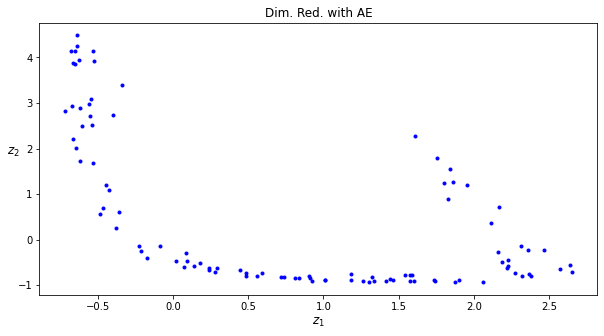

In [88]:
codings_val = activation(tf.matmul(X_train,mini_ae.w1) + mini_ae.b1) # we plot the input with dimension reduction

fig = plt.figure(figsize=(10,5))
plt.plot(codings_val[:,0], codings_val[:,1], "b.")
plt.xlabel("$z_1$", fontsize=12)
plt.ylabel("$z_2$", fontsize=12, rotation=0)
plt.title('Dim. Red. with AE')
plt.show()

Although it is no exact measurement, it seems that the above figure is a projection in a 2D plane of the 3D points we plotted earlier. It confirms the fact that dimension reduction manages to capture the most significant features and tendencies of the original dataset.
The evolution of the loss function plotted below will show that the reconstruction is a good approximation of the original data :

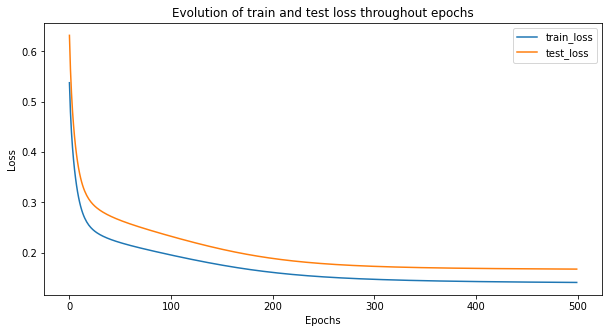

In [89]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.title("Evolution of train and test loss throughout epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train_loss", "test_loss"])

### PCA

In [90]:
# PCA from scikit-learn
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

singval = pca.singular_values_   # eigenvalues
comp = pca.components_           # principal components
proj = pca.transform(X_train)    # computes the projection coefficients

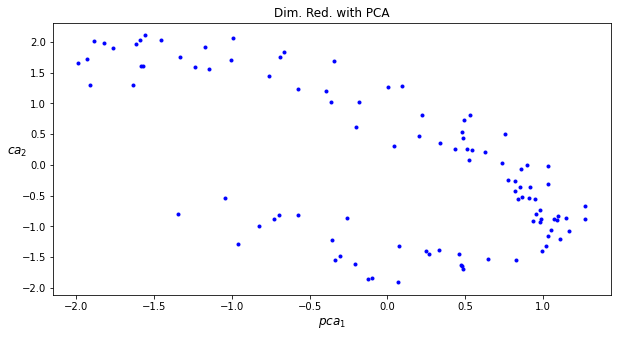

In [91]:
proj_pca = np.dot(proj, comp[0:2,:].T)

fig = plt.figure(figsize=(10,5))
plt.plot(proj_pca[:,0], proj_pca[:, 1], "b.")
plt.xlabel("$pca_1$", fontsize=12)
plt.ylabel("$ca_2$", fontsize=12, rotation=0)
plt.title('Dim. Red. with PCA')
plt.show()

# Exercise 2: AE for representation learning with MNIST

## Dataset import

In [92]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Constants

In [93]:
n = x_train.shape[0]
d_inputs = 28 * 28
d_hidden1 = 100
d_hidden2 = 10  # codings
d_hidden3 = d_hidden1
d_outputs = d_inputs
n_class = 10

learning_rate = 1e-1
l2_reg = 0.0005
batch_size = 10
steps = n//batch_size
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=500,
    decay_rate=0.96)

## Dataset formatting

In [94]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))/255 - 0.5
x_train = x_train.astype('float32')
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]))/255 - 0.5
x_test = x_test.astype('float32')

## Model definition

In [145]:
class AE(tf.Module):
    def __init__(self, unit_nbrs, name=None):
        super().__init__(name=name)
        self.w = []
        self.b = []
        self.K = len(unit_nbrs)-1

        for i in range(self.K): 
            self.w.append(tf.Variable(tf.random.normal([unit_nbrs[i], unit_nbrs[i+1]], name='w')))
            self.b.append(tf.Variable(tf.zeros([unit_nbrs[i+1]]), name='b'+ str(i+1)))

        for i in range(self.K-1):  
            self.b.append(tf.Variable(tf.zeros([self.w[-i].shape[1]]), name='b' + str(self.K+1) + str(i)))

        self.b.append(tf.Variable(tf.zeros(unit_nbrs[0]), name= 'b' + str(len(self.b)+1)))
        
    @tf.function
    def __call__(self, x):
        z = [activation(tf.matmul(x,self.w[0]) + self.b[0])]

        for i in range(1, self.K):  
            z.append(activation(tf.matmul(z[i-1],self.w[i]) + self.b[i]))

        for i in range(0, self.K):
            z.append(activation(tf.matmul(z[self.K+i-1],tf.transpose(self.w[self.K-i-1])) + self.b[self.K+i]))

        return z[-1]
    
def loss(target,pred):
    return tf.math.reduce_mean(tf.math.squared_difference(target, pred))  

def reg(model,l2_reg):
    term = 0
    for coef in model.trainable_variables:
        if (coef.name[0]=='w'):
            term += coef^2
    return l2_reg*term

## Model creation

In [149]:
my_AE = AE([d_inputs,d_hidden1,d_hidden2], name="the_model")
print("Model results:", my_AE(x_train[0:2]))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Model results: tf.Tensor(
[[ 9.9273206e+02  3.3736084e+01 -1.0000000e+00 ...  1.9777866e+03
   6.0448608e+00  9.9959831e+01]
 [ 8.1924030e+02  5.7344604e+02 -1.0000000e+00 ...  1.7458373e+03
   1.3165479e+02  6.3309430e+02]], shape=(2, 784), dtype=float32)


In [150]:
n_epochs = 4

import logging
logging.getLogger('tensorflow').disabled = True # Removes warning messages to reduce visual clutter

steps = 60 # we multiply the batch size by 10 compared to what was initially set because of the computation times

for epoch in range(n_epochs):
    for step in range(steps):
        # Computing the function meanwhile recording a gradient tape
        with tf.GradientTape() as tape: 
            train_loss = loss(x_train,my_AE(x_train)) + reg(my_AE, l2_reg)
            grads = tape.gradient(train_loss,my_AE.trainable_variables)
            optimizer.apply_gradients(zip(grads, my_AE.trainable_variables))
            print("\rEpoch %d - %d%% - \tf=%s" % (epoch, int(step/steps*100), train_loss.numpy()),end="")
    

Epoch 3 - 98% - 	f=0.48585498

## Call with random results

Inputs: [-0.5 -0.5 -0.5 -0.5 -0.5]
Model results: tf.Tensor([-1. -1. -1. -1. -1.], shape=(5,), dtype=float32)
Test MSE = tf.Tensor(0.48956504, shape=(), dtype=float32)


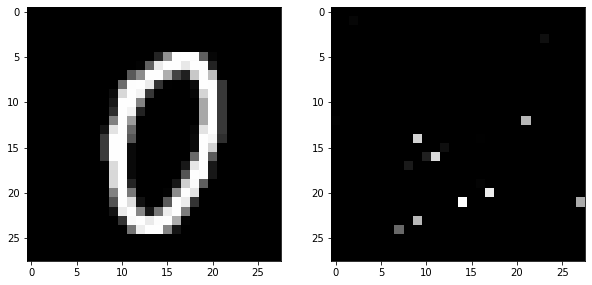

In [153]:
ind = 1000
print("Inputs:", x_train[ind:ind+1][0,:5])
print("Model results:", my_AE(x_train[ind:ind+1])[0,:5])
x_original = x_train[ind:ind+1]
x_tilde = my_AE(x_train[ind:ind+1]).numpy()

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(np.reshape(x_original,(28,28)), cmap='gray', interpolation="nearest")
plt.subplot(122)
plt.imshow(np.reshape(x_tilde,(28,28)), cmap='gray', interpolation="nearest")

x_tilde_test = my_AE(x_test)
test_loss = loss(x_test,x_tilde_test)
print("Test MSE =",test_loss)

It seems that the reconstruction doesn't give the intended results as the network always returns the same output image, no matter what image is used as input. It is very likely an implementation error on our part, but we didn't manage to find where it is. We can notice that the loss decreases during training, which shows that the error might originate from the way we return `x_tilde`.